# Estimating Gestational Diabetes Onset
### Reverse Timeseries Forecasting

## Data Wrangling

<ul>
    <li><a href="#Gathering-the-data"><strong>Gathering the data</strong></a></li>
	<li><a href="#Imports"><strong>Imports</strong></a></li>
	<li><a href="#Notebook-Settings"><strong>Notebook Settings</a></li>
	<li><a href="#Load-the-data"><strong>Loading the data</strong></a>
		<ul>
			<li>Fixing datatypes</li>
			<li>Setting the index</li>
		</ul>
	</li>
	<li><a href="#Feature-Extraction"><strong>Feature Extraction</strong></a>
		<ul>
			<li>Daycount</li>
			<li>Subtypes</li>
			<li>outOfRange</li>
		</ul>
	</li>
	<li><a href="#Daily-dataframe"><strong>Daily dataframe</strong></a>
		<ul>
			<li>bg_fasting</li>
			<li>bg_avg</li>
			<li>carbs_sum</li>
			<li>meds_dose</li>
		</ul>
	</li>
	<li><a href="#Light-Data-Visualization"><strong>Light Data Visualization</strong></a></li>
    <li><a href="#Setting-the-target-variable"><strong>Setting the target variable</strong></a></li>
	<li><a href="#Saving-the-data"><strong>Saving the data</strong></a></li>
</ul>


### Gathering the data

<p>All of the data had been saved to a mobile app called One Touch Reveal, a popular tracking app for people with diabetes and their healthcare professionals.</p>
<p>Although the data was available in the webapp, and I did successfully scrape it and build a working dataset, the notes column did not include the notes I had saved in the mobile app while tracking this data. I wasn't planning on using those notes for forecasting but they are extremely useful to have for the feature engineering step, so I wanted to have them. To do this I was able to export the data from the mobile app, after changing my system date to the last day that had records because the export function did not allow custom dates. Once I had an export I copied it into a Google Sheet and then moved it into this directory on my laptop.</p>

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import itertools

from library.sb_utils import save_file

### Notebook Settings

In [2]:
pd.set_option('display.max_rows', 500)

### Load the data

In [3]:
data = pd.read_csv('data/onetouch-mobile-export.csv', header=0, engine='python', skipfooter=1)
data.tail()

,Item Type,Date and Time,Value,Unit,Notes
733,Carbs,"Mar 11, 2021, 1:30 PM",30,g,Estimate! Harvest Bowl from Retreat. Carbs: qu...
734,Carbs,"Mar 11, 2021, 11:18 AM",27,g,1 piece toast with peanut butter and sliced ba...
735,Blood Sugar Reading,"Mar 11, 2021, 9:20 AM",121,mg/dL,20 minutes late... Struggled with puncture depth
736,Carbs,"Mar 11, 2021, 8:01 AM",26,g,Eggs on toast (2 pieces) with cheese
737,Blood Sugar Reading,"Mar 11, 2021, 7:11 AM",104,mg/dL,NaN


In [4]:
data.rename(columns={'Item Type': 'type', 'Date and Time': 'datetime', 'Value': 'value', 'Unit': 'unit', 'Notes':'notes'}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   type      738 non-null    object
 1   datetime  738 non-null    object
 2   value     738 non-null    int64 
 3   unit      738 non-null    object
 4   notes     472 non-null    object
dtypes: int64(1), object(4)
memory usage: 29.0+ KB


**Let's fix some datatypes!**

In [5]:
data.dtypes

type        object
datetime    object
value        int64
unit        object
notes       object
dtype: object

In [6]:
data.datetime = pd.to_datetime(data.datetime)

In [7]:
data.dtypes

type                object
datetime    datetime64[ns]
value                int64
unit                object
notes               object
dtype: object

**We need an index. Since this is a timeseries it should be the timeseries**

In [8]:
# Double check that all of the indeces are unique
len(data.datetime.unique()), len(data)

(738, 738)

In [9]:
# Good to go!
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

In [10]:
data.head()

,type,value,unit,notes
datetime,,,,
2021-03-11 07:11:00,Blood Sugar Reading,104,mg/dL,NaN
2021-03-11 08:01:00,Carbs,26,g,Eggs on toast (2 pieces) with cheese
2021-03-11 09:20:00,Blood Sugar Reading,121,mg/dL,20 minutes late... Struggled with puncture depth
2021-03-11 11:18:00,Carbs,27,g,1 piece toast with peanut butter and sliced ba...
2021-03-11 13:30:00,Carbs,30,g,Estimate! Harvest Bowl from Retreat. Carbs: qu...


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 738 entries, 2021-03-11 07:11:00 to 2021-05-26 18:13:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    738 non-null    object
 1   value   738 non-null    int64 
 2   unit    738 non-null    object
 3   notes   472 non-null    object
dtypes: int64(1), object(3)
memory usage: 28.8+ KB


**Let's take a peek at the data so far**

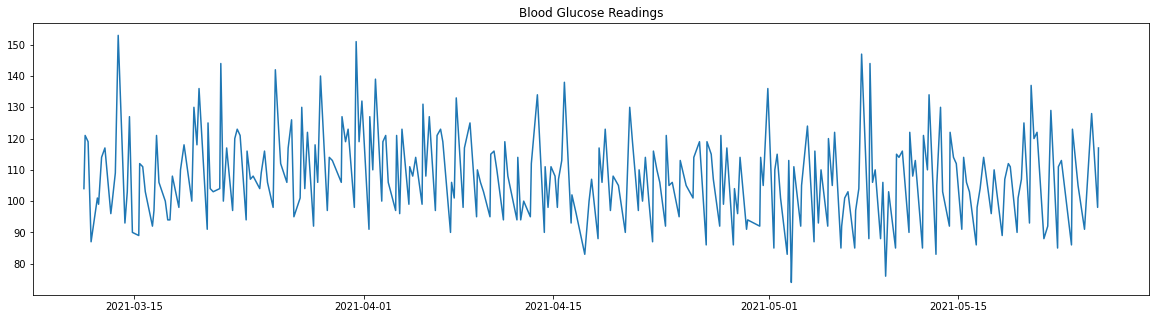

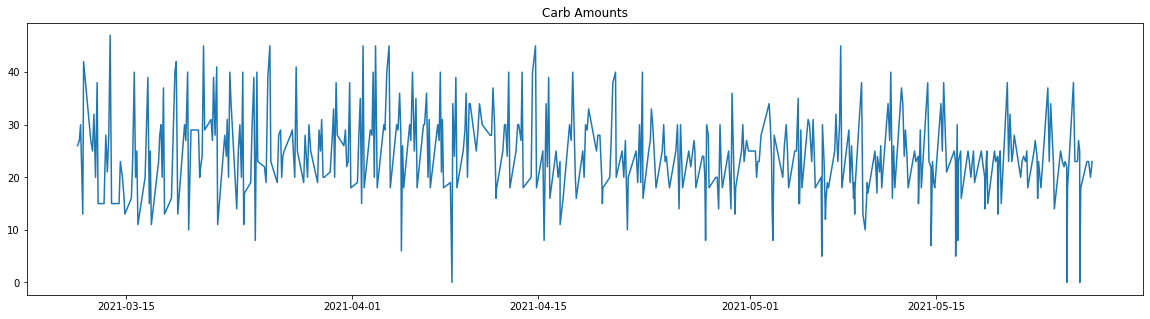

In [12]:
bg = data[data.type == 'Blood Sugar Reading']

plt.figure(figsize=(20,5))
plt.plot(bg.index, bg.value)
plt.title('Blood Glucose Readings')
plt.show()

carb = data[data.type == 'Carbs']

plt.figure(figsize=(20,5))
plt.plot(carb.index, carb.value)
plt.title('Carb Amounts')
plt.show()

**Are those some 0 values for Carbs? We don't need those**

In [13]:
data[data.value == 0]

,type,value,unit,notes
datetime,,,,
2021-04-08 13:00:00,Carbs,0,g,Slept through snack time
2021-05-24 20:29:00,Carbs,0,g,1/4 Pinkabella cookie dough cupcake
2021-05-25 19:56:00,Carbs,0,g,1/4 Pinkabella cookie dough cupcake


In [14]:
data = data[data.value > 0]

In [15]:
data.describe()

,value
count,735.000000
mean,57.190476
std,41.858548
min,5.000000
25%,23.000000
50%,30.000000
75%,101.000000
max,153.000000


### Feature Extraction
<ul>
    <li>'month': calendar month</li>
    <li>'daycount': days since the first reading</li>
    <li>'subtype'</li>
</ul>

In [16]:
# calendar month
data['month'] = data.index.month

#### Daycount

In [17]:
#days since the first reading
# make a list of days
days = pd.DataFrame(np.unique(data.index.date))
days.index += 1 
days.reset_index().set_index(0)
days = days.to_dict()[0]
days = {v: k for k, v in days.items()}
dict(itertools.islice(days.items(), 0 ,5))

{datetime.date(2021, 3, 11): 1,
 datetime.date(2021, 3, 12): 2,
 datetime.date(2021, 3, 13): 3,
 datetime.date(2021, 3, 14): 4,
 datetime.date(2021, 3, 15): 5}

In [18]:
# make new column and map day to timestamp
data['date'] = data.index.date
data['daycount'] = data['date'].map(days)
data

,type,value,unit,notes,month,date,daycount
datetime,,,,,,,
2021-03-11 07:11:00,Blood Sugar Reading,104,mg/dL,NaN,3,2021-03-11,1
2021-03-11 08:01:00,Carbs,26,g,Eggs on toast (2 pieces) with cheese,3,2021-03-11,1
2021-03-11 09:20:00,Blood Sugar Reading,121,mg/dL,20 minutes late... Struggled with puncture depth,3,2021-03-11,1
2021-03-11 11:18:00,Carbs,27,g,1 piece toast with peanut butter and sliced ba...,3,2021-03-11,1
2021-03-11 13:30:00,Carbs,30,g,Estimate! Harvest Bowl from Retreat. Carbs: qu...,3,2021-03-11,1
...,...,...,...,...,...,...,...
2021-05-25 21:40:00,Carbs,18,g,Atkins bar,5,2021-05-25,76
2021-05-26 08:53:00,Carbs,23,g,"Breakfast burrito, 1/2 cup Fairlife milk",5,2021-05-26,77
2021-05-26 12:00:00,Carbs,23,g,Rx bar,5,2021-05-26,77


In [19]:
data[data.type == 'Blood Sugar Reading'].daycount.value_counts()

36    5
43    5
53    5
1     4
56    4
2     4
41    4
42    4
44    4
47    4
48    4
49    4
51    4
52    4
55    4
57    4
33    4
58    4
59    4
60    4
61    4
62    4
63    4
64    4
65    4
66    4
67    4
69    4
70    4
71    4
35    4
39    4
18    4
9     4
11    4
12    4
13    4
14    4
15    4
16    4
17    4
8     4
7     4
6     4
20    4
21    4
22    4
23    4
24    4
5     4
4     4
25    4
26    4
27    4
28    4
3     4
30    4
31    4
10    4
68    3
72    3
73    3
74    3
32    3
34    3
54    3
19    3
46    3
45    3
40    3
29    3
38    3
37    3
50    2
75    2
76    2
Name: daycount, dtype: int64

In [20]:
# what are the three with 5 blood sugar readings?
data[(data.type == 'Blood Sugar Reading') & ((data.daycount == 36) | (data.daycount == 43) | (data.daycount == 53))]

,type,value,unit,notes,month,date,daycount
datetime,,,,,,,
2021-04-15 04:08:00,Blood Sugar Reading,108,mg/dL,NaN,4,2021-04-15,36
2021-04-15 08:16:00,Blood Sugar Reading,98,mg/dL,NaN,4,2021-04-15,36
2021-04-15 10:18:00,Blood Sugar Reading,107,mg/dL,NaN,4,2021-04-15,36
2021-04-15 16:05:00,Blood Sugar Reading,113,mg/dL,NaN,4,2021-04-15,36
2021-04-15 20:45:00,Blood Sugar Reading,138,mg/dL,NaN,4,2021-04-15,36
2021-04-22 02:50:00,Blood Sugar Reading,100,mg/dL,NaN,4,2021-04-22,43
2021-04-22 09:27:00,Blood Sugar Reading,87,mg/dL,This is actually my fasting number.,4,2021-04-22,43
2021-04-22 10:54:00,Blood Sugar Reading,116,mg/dL,NaN,4,2021-04-22,43
2021-04-22 17:06:00,Blood Sugar Reading,110,mg/dL,NaN,4,2021-04-22,43


**We don't need the overnight BG readings for this application**

In [21]:
data[data.index.hour < 5]

,type,value,unit,notes,month,date,daycount
datetime,,,,,,,
2021-04-15 04:08:00,Blood Sugar Reading,108,mg/dL,NaN,4,2021-04-15,36
2021-04-22 02:50:00,Blood Sugar Reading,100,mg/dL,NaN,4,2021-04-22,43


In [22]:
data.drop(data[data.index.hour < 5].index, inplace=True)

**or the double afternoon reading**

In [23]:
data.drop(data[data.index == '2021-05-02 15:54:00'].index, inplace=True)

In [24]:
data[data.type == 'Blood Sugar Reading'].daycount.value_counts().value_counts()

4    59
3    14
2     3
Name: daycount, dtype: int64

In [25]:
data.head()

,type,value,unit,notes,month,date,daycount
datetime,,,,,,,
2021-03-11 07:11:00,Blood Sugar Reading,104,mg/dL,NaN,3,2021-03-11,1
2021-03-11 08:01:00,Carbs,26,g,Eggs on toast (2 pieces) with cheese,3,2021-03-11,1
2021-03-11 09:20:00,Blood Sugar Reading,121,mg/dL,20 minutes late... Struggled with puncture depth,3,2021-03-11,1
2021-03-11 11:18:00,Carbs,27,g,1 piece toast with peanut butter and sliced ba...,3,2021-03-11,1
2021-03-11 13:30:00,Carbs,30,g,Estimate! Harvest Bowl from Retreat. Carbs: qu...,3,2021-03-11,1


In [26]:
data.daycount.value_counts().value_counts()

10    29
9     27
11     9
8      9
12     2
4      1
Name: daycount, dtype: int64

**It looks like, despite aiming for 4 blood sugar readings and 6 carb records per day, just about half of the days are missing one record. I'll have to set some good conditions to figure out the subtypes**

In [27]:
# what does a day with only 9 records look like? (should have 10)
missing_one = data[data.daycount.isin((data.daycount.value_counts() == 9).keys())]
missing_one[missing_one.daycount == 3]

,type,value,unit,notes,month,date,daycount
datetime,,,,,,,
2021-03-13 06:58:00,Blood Sugar Reading,96,mg/dL,NaN,3,2021-03-13,3
2021-03-13 07:53:00,Carbs,15,g,Breakfast burrito,3,2021-03-13,3
2021-03-13 08:56:00,Blood Sugar Reading,99,mg/dL,NaN,3,2021-03-13,3
2021-03-13 11:05:00,Carbs,28,g,Yogurt and raspberries,3,2021-03-13,3
2021-03-13 13:56:00,Carbs,21,g,"Broccoli cheddar soup, crackers",3,2021-03-13,3
2021-03-13 14:59:00,Blood Sugar Reading,109,mg/dL,NaN,3,2021-03-13,3
2021-03-13 16:30:00,Carbs,28,g,1/2 Smoothie: same as yesterday plus 1/4 avoca...,3,2021-03-13,3
2021-03-13 18:58:00,Carbs,47,g,Leftover cauliflower and broccoli pizza,3,2021-03-13,3
2021-03-13 20:04:00,Blood Sugar Reading,153,mg/dL,"Had an extra slice of pizza, but only went ove...",3,2021-03-13,3


#### Subtypes

In [28]:
def subtypes_current(df_day, df):
    
    for r in range(len(df_day)):
        current_index = df_day.iloc[r].name
        current = df.loc[current_index]
        current_type = current.type

        if current.isna().subtype:
            if current_type == 'Blood Sugar Reading':
                if r == 0:
                    df.loc[current_index, 'subtype'] = 'fasting'
                elif (current_index.hour > 12) & (current_index.hour < 19):
                    df.loc[current_index, 'subtype'] = 'after_lunch'
                elif current_index.hour > 18:
                    df.loc[current_index, 'subtype'] = 'after_dinner'
            elif current_type == 'Carbs':
                if r == 0:
                    df.loc[current_index, 'subtype'] = 'breakfast'
                elif r+1 == len(df_day):
                    df.loc[current_index, 'subtype'] = 'snack_night'
    
    return df

In [29]:
def subtypes_previous(df_day, df):
    
    for r in range(len(df_day)):
        current_index = df_day.iloc[r].name
        current = df.loc[current_index]
        current_type = current.type
        previous_index = df_day.iloc[r-1].name
        previous = df.loc[previous_index]
        previous_type = previous.type

        if current.isna().subtype:
            if current_type == 'Blood Sugar Reading':
                if previous['subtype'] == 'fasting':
                    df.loc[current_index, 'subtype'] = 'after_breakfast'
                elif previous_type == 'Carbs':
                    if previous['subtype'] == 'breakfast':
                        df.loc[current_index, 'subtype'] = 'after_breakfast'
                    elif previous['subtype'] == 'lunch':
                        df.loc[current_index, 'subtype'] = 'after_lunch'
                    elif previous['subtype'] == 'dinner':
                        df.loc[current_index, 'subtype'] = 'after_dinner'
            elif current_type == 'Carbs':
                if previous_type == 'Blood Sugar Reading':
                    if previous['subtype'] == 'fasting':
                        df.loc[current_index, 'subtype'] = 'breakfast'
                    elif previous['subtype'] == 'after_breakfast':
                        df.loc[current_index, 'subtype'] = 'snack_morning'
                    elif previous['subtype'] == 'after_lunch':
                        df.loc[current_index, 'subtype'] = 'snack_afternoon'
                    elif previous['subtype'] == 'after_dinner':
                        df.loc[current_index, 'subtype'] = 'snack_night'
                    elif (previous['subtype'] == 'snack_night') | (r+1 == len(df_day)):
                        df.loc[current_index, 'subtype'] = 'snack_night'
                elif previous_type == 'Carbs':
                    if previous['subtype'] == 'snack_morning':
                        df.loc[current_index, 'subtype'] = 'lunch'
                    elif previous['subtype'] == 'snack_night':
                        df.loc[current_index, 'subtype'] = 'snack_night'
    return df

In [30]:
def subtypes_following(df_day, df):
    
    for r in range(len(df_day)):
        current_index = df_day.iloc[r].name
        current = df.loc[current_index]
        current_type = current.type
        previous_index = df_day.iloc[r-1].name
        previous = df.loc[previous_index]
        previous_type = previous.type

        if current.isna().subtype:
            if r+1 < len(df_day):
                following_index = df_day.iloc[r+1].name
                following = df.loc[following_index]
                following_type = following.type

                if current_type == 'Carbs':
                    if following_type == 'Blood Sugar Reading':
                        if following['subtype'] == 'after_lunch':
                            df.loc[current_index, 'subtype'] = 'lunch'
                        elif following['subtype'] == 'after_dinner':
                            df.loc[current_index, 'subtype'] = 'dinner'
                    elif following_type == 'Carbs':
                        if following['subtype'] == 'lunch':
                            df.loc[current_index, 'subtype'] = 'snack_breakfast'
                        elif following['subtype'] == 'dinner':
                            df.loc[current_index, 'subtype'] = 'snack_afternoon'
    
    return df

In [31]:
# loop through daycounts to save subtypes
# BG: fasting, meal
# Carbs: breakfast, snack, lunch, dinner

#TODO: move to external file


def add_subtypes(df):
    
    # loop through and set subtypes on perfect days
    for i in range(1, len(df.daycount.unique())): 
        df_day = df[df.daycount == i]
        bg = df_day[df_day.type == 'Blood Sugar Reading']
        carbs = df_day[df_day.type == 'Carbs']
        
        types = ['Blood Sugar Reading', 'Carbs', 'Blood Sugar Reading', 'Carbs', 'Carbs', 'Blood Sugar Reading', 'Carbs', 'Carbs', 'Blood Sugar Reading', 'Carbs']
        subtypes = ['fasting', 'breakfast', 'after_breakfast', 'snack_morning', 'lunch', 'after_lunch', 'snack_afternoon', 'dinner', 'after_dinner', 'snack_night']
        
        num_all = len(df_day)
        num_bg = len(bg)
        num_carbs = len(carbs)
        
        if ((num_bg == 4) & (num_carbs == 6)):
            for d in range(num_all):
                if df.loc[df_day.iloc[d].name, 'type'] == types[d]:
                    df.loc[df_day.iloc[d].name, 'subtype'] = subtypes[d]

    # TODO: make function for below conditions
    # Have to run below more than once because I had to build conditionals around previous and following values
    
    #run 3 times
    
    for x in range(1, 4):

        empty_subtypes = df[df['subtype'].isnull()]
        daycount_with_nulls = df[df.daycount.isin(empty_subtypes.daycount.unique())]
        
        for i in daycount_with_nulls.daycount.unique(): 
            df_day = df[df.daycount == i]
            
            # loop through with current conditions
            df = subtypes_current(df_day, df)

            # loop through with previous conditions
            df = subtypes_previous(df_day, df)
            
            # loop through with following conditins
            df = subtypes_following(df_day, df)

            # loop through looking at both previous and following
            for r in range(len(df_day)):
                current_index = df_day.iloc[r].name
                current = df.loc[current_index]
                current_type = current.type
                previous_index = df_day.iloc[r-1].name
                previous = df.loc[previous_index]
                previous_type = previous.type

                if current.isna().subtype:
                    if r+1 < len(df_day):
                        following_index = df_day.iloc[r+1].name
                        following = df.loc[following_index]
                        following_type = following.type

                        if current_type == 'Carbs':
                            if ((following_type == 'Carbs') & ~following.isna().subtype) & ((previous_type == 'Carbs') &  ~previous.isna().subtype):
                                if (current_index - previous_index) < (following_index - current_index):
                                    df.loc[current_index, 'subtype'] = previous['subtype']
                                else:
                                    df.loc[current_index, 'subtype'] = following['subtype']



        if x == 1:
        # schedule --> to see if I can identify subtypes based on their timestamps
        # requires that a good portion of subtypes have been filled in correctly
            data_with_subtypes = df[~df['subtype'].isnull()]
            schedule = {
                'G fasting': data_with_subtypes[data_with_subtypes.subtype == 'fasting'].index.hour.unique().sort_values().values,
                'C breakfast': data_with_subtypes[data_with_subtypes.subtype == 'breakfast'].index.hour.unique().sort_values().values,
                'G after_breakfast': data_with_subtypes[data_with_subtypes.subtype == 'after_breakfast'].index.hour.unique().sort_values().values,
                'C snack_morning': data_with_subtypes[data_with_subtypes.subtype == 'snack_morning'].index.hour.unique().sort_values().values,
                'C lunch': data_with_subtypes[data_with_subtypes.subtype == 'lunch'].index.hour.unique().sort_values().values,
                'G after_lunch': data_with_subtypes[data_with_subtypes.subtype == 'after_lunch'].index.hour.unique().sort_values().values,
                'C snack_afternoon': data_with_subtypes[data_with_subtypes.subtype == 'snack_afternoon'].index.hour.unique().sort_values().values,
                'C dinner': data_with_subtypes[data_with_subtypes.subtype == 'dinner'].index.hour.unique().sort_values().values,
                'G after_dinner': data_with_subtypes[data_with_subtypes.subtype == 'after_dinner'].index.hour.unique().sort_values().values,
                'C snack_night': data_with_subtypes[data_with_subtypes.subtype == 'snack_night'].index.hour.unique().sort_values().values,
            }

        the_rest = df[df['subtype'].isnull()]
        outstanding_subtype_nulls = df[df.daycount.isin(the_rest.daycount.unique())]
        print(x, outstanding_subtype_nulls.daycount.unique())

    return df, outstanding_subtype_nulls, schedule


In [32]:
df, outstanding, schedule = add_subtypes(data)
df.head(20)

1 [50 75 76 77]
2 [50 75 76 77]
3 [50 75 76 77]


,type,value,unit,notes,month,date,daycount,subtype
datetime,,,,,,,,
2021-03-11 07:11:00,Blood Sugar Reading,104,mg/dL,NaN,3,2021-03-11,1,fasting
2021-03-11 08:01:00,Carbs,26,g,Eggs on toast (2 pieces) with cheese,3,2021-03-11,1,breakfast
2021-03-11 09:20:00,Blood Sugar Reading,121,mg/dL,20 minutes late... Struggled with puncture depth,3,2021-03-11,1,after_breakfast
2021-03-11 11:18:00,Carbs,27,g,1 piece toast with peanut butter and sliced ba...,3,2021-03-11,1,snack_morning
2021-03-11 13:30:00,Carbs,30,g,Estimate! Harvest Bowl from Retreat. Carbs: qu...,3,2021-03-11,1,lunch
2021-03-11 14:35:00,Blood Sugar Reading,119,mg/dL,NaN,3,2021-03-11,1,after_lunch
2021-03-11 17:30:00,Carbs,13,g,Carrots and Bitchin' Sauce,3,2021-03-11,1,snack_afternoon
2021-03-11 18:55:00,Carbs,42,g,Tacos with black beans,3,2021-03-11,1,dinner
2021-03-11 19:54:00,Blood Sugar Reading,87,mg/dL,Might have tested slightly before an hour. Did...,3,2021-03-11,1,after_dinner


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2021-03-11 07:11:00 to 2021-05-26 18:13:00
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   type      732 non-null    object
 1   value     732 non-null    int64 
 2   unit      732 non-null    object
 3   notes     469 non-null    object
 4   month     732 non-null    int64 
 5   date      732 non-null    object
 6   daycount  732 non-null    int64 
 7   subtype   724 non-null    object
dtypes: int64(3), object(5)
memory usage: 67.6+ KB


In [34]:
outstanding = outstanding.reset_index().set_index(['daycount', 'datetime'])
outstanding

type  value   unit  \
daycount datetime                                                 
50       2021-04-29 08:21:00  Blood Sugar Reading     91  mg/dL   
         2021-04-29 09:07:00                Carbs     25      g   
         2021-04-29 10:20:00  Blood Sugar Reading     94  mg/dL   
         2021-04-29 13:20:00                Carbs     14      g   
         2021-04-29 15:15:00                Carbs     36      g   
         2021-04-29 18:23:00                Carbs     22      g   
         2021-04-29 20:43:00                Carbs     13      g   
         2021-04-29 21:47:00                Carbs     18      g   
75       2021-05-24 08:47:00  Blood Sugar Reading     91  mg/dL   
         2021-05-24 09:14:00                Carbs     25      g   
         2021-05-24 12:33:00                Carbs     23      g   
         2021-05-24 15:19:00                Carbs     22      g   
         2021-05-24 17:22:00                Carbs     23      g   
         2021-05-24 20:22:00                Carbs     22      g   
         2021-05-24 21:25:00  Blood Sugar Reading    128  mg/dL   
         2021-05-24 21:52:00                Carbs     18      g   
76       2021-05-25 08:05:00  Blood Sugar Reading     98  mg/dL   
         2021-05-25 08:29:00                Carbs     38      g   
         2021-05-25 09:35:00  Blood Sugar Reading    117  mg/dL   
         2021-05-25 11:08:00                Carbs     23      g   
         2021-05-25 15:47:00                Carbs     23      g   
         2021-05-25 17:39:00                Carbs     27      g   
         2021-05-25 19:47:00                Carbs     25      g   
         2021-05-25 21:40:00                Carbs     18      g   
77       2021-05-26 08:53:00                Carbs     23      g   
         2021-05-26 12:00:00                Carbs     23      g   
         2021-05-26 15:21:00                Carbs     20      g   
         2021-05-26 18:13:00                Carbs     23      g   

                                                                          notes  \
daycount datetime                                                                 
50       2021-04-29 08:21:00                     Added 4th metformin last night   
         2021-04-29 09:07:00  Alki sausage breakfast sandwich with top bread...   
         2021-04-29 10:20:00                                                NaN   
         2021-04-29 13:20:00                              Broccoli cheddar soup   
         2021-04-29 15:15:00    Peanut butter on 1 slice bread, frozen kind bar   
         2021-04-29 18:23:00                    Chicken salad wrap with avocado   
         2021-04-29 20:43:00                                  Chocolate almonds   
         2021-04-29 21:47:00                                         Atkins bar   
75       2021-05-24 08:47:00                                                NaN   
         2021-05-24 09:14:00                  Breakfast burrito, gummy vitamins   
         2021-05-24 12:33:00                                             Rx bar   
         2021-05-24 15:19:00                                Chicken Caesar wrap   
         2021-05-24 17:22:00                                             Rx bar   
         2021-05-24 20:22:00                                Chicken Caesar wrap   
         2021-05-24 21:25:00                                                NaN   
         2021-05-24 21:52:00                                         Atkins bar   
76       2021-05-25 08:05:00                                                NaN   
         2021-05-25 08:29:00               Steel cut oatmeal with peanut butter   
         2021-05-25 09:35:00                                                NaN   
         2021-05-25 11:08:00                                             Rx bar   
         2021-05-25 15:47:00  Chicken and wild rice soup, 1/2 cup Fairlife milk   
         2021-05-25 17:39:00                      Rx bar, 1 chocolate nonpareil   
         2021-05-25 19:47:00         Chick

In [35]:
outstanding.loc[(50, '2021-04-29 18:23:00'), 'subtype'] = 'dinner'
outstanding.loc[(50, '2021-04-29 20:43:00'), 'subtype'] = 'snack_night'
outstanding

type  value   unit  \
daycount datetime                                                 
50       2021-04-29 08:21:00  Blood Sugar Reading     91  mg/dL   
         2021-04-29 09:07:00                Carbs     25      g   
         2021-04-29 10:20:00  Blood Sugar Reading     94  mg/dL   
         2021-04-29 13:20:00                Carbs     14      g   
         2021-04-29 15:15:00                Carbs     36      g   
         2021-04-29 18:23:00                Carbs     22      g   
         2021-04-29 20:43:00                Carbs     13      g   
         2021-04-29 21:47:00                Carbs     18      g   
75       2021-05-24 08:47:00  Blood Sugar Reading     91  mg/dL   
         2021-05-24 09:14:00                Carbs     25      g   
         2021-05-24 12:33:00                Carbs     23      g   
         2021-05-24 15:19:00                Carbs     22      g   
         2021-05-24 17:22:00                Carbs     23      g   
         2021-05-24 20:22:00                Carbs     22      g   
         2021-05-24 21:25:00  Blood Sugar Reading    128  mg/dL   
         2021-05-24 21:52:00                Carbs     18      g   
76       2021-05-25 08:05:00  Blood Sugar Reading     98  mg/dL   
         2021-05-25 08:29:00                Carbs     38      g   
         2021-05-25 09:35:00  Blood Sugar Reading    117  mg/dL   
         2021-05-25 11:08:00                Carbs     23      g   
         2021-05-25 15:47:00                Carbs     23      g   
         2021-05-25 17:39:00                Carbs     27      g   
         2021-05-25 19:47:00                Carbs     25      g   
         2021-05-25 21:40:00                Carbs     18      g   
77       2021-05-26 08:53:00                Carbs     23      g   
         2021-05-26 12:00:00                Carbs     23      g   
         2021-05-26 15:21:00                Carbs     20      g   
         2021-05-26 18:13:00                Carbs     23      g   

                                                                          notes  \
daycount datetime                                                                 
50       2021-04-29 08:21:00                     Added 4th metformin last night   
         2021-04-29 09:07:00  Alki sausage breakfast sandwich with top bread...   
         2021-04-29 10:20:00                                                NaN   
         2021-04-29 13:20:00                              Broccoli cheddar soup   
         2021-04-29 15:15:00    Peanut butter on 1 slice bread, frozen kind bar   
         2021-04-29 18:23:00                    Chicken salad wrap with avocado   
         2021-04-29 20:43:00                                  Chocolate almonds   
         2021-04-29 21:47:00                                         Atkins bar   
75       2021-05-24 08:47:00                                                NaN   
         2021-05-24 09:14:00                  Breakfast burrito, gummy vitamins   
         2021-05-24 12:33:00                                             Rx bar   
         2021-05-24 15:19:00                                Chicken Caesar wrap   
         2021-05-24 17:22:00                                             Rx bar   
         2021-05-24 20:22:00                                Chicken Caesar wrap   
         2021-05-24 21:25:00                                                NaN   
         2021-05-24 21:52:00                                         Atkins bar   
76       2021-05-25 08:05:00                                                NaN   
         2021-05-25 08:29:00               Steel cut oatmeal with peanut butter   
         2021-05-25 09:35:00                                                NaN   
         2021-05-25 11:08:00                                             Rx bar   
         2021-05-25 15:47:00  Chicken and wild rice soup, 1/2 cup Fairlife milk   
         2021-05-25 17:39:00                      Rx bar, 1 chocolate nonpareil   
         2021-05-25 19:47:00         Chick

In [36]:
df.loc['2021-04-29 18:23:00', 'subtype'] = 'dinner'
df.loc['2021-04-29 20:43:00', 'subtype'] = 'snack_night'

In [37]:
outstanding.loc[50].index

DatetimeIndex(['2021-04-29 08:21:00', '2021-04-29 09:07:00',
               '2021-04-29 10:20:00', '2021-04-29 13:20:00',
               '2021-04-29 15:15:00', '2021-04-29 18:23:00',
               '2021-04-29 20:43:00', '2021-04-29 21:47:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

In [38]:
outstanding.drop(50, level=0, axis=0, inplace=True)

In [39]:
outstanding = outstanding.reset_index().set_index('datetime')
outstanding

,daycount,type,value,unit,notes,month,date,subtype
datetime,,,,,,,,
2021-05-24 08:47:00,75,Blood Sugar Reading,91,mg/dL,NaN,5,2021-05-24,fasting
2021-05-24 09:14:00,75,Carbs,25,g,"Breakfast burrito, gummy vitamins",5,2021-05-24,breakfast
2021-05-24 12:33:00,75,Carbs,23,g,Rx bar,5,2021-05-24,NaN
2021-05-24 15:19:00,75,Carbs,22,g,Chicken Caesar wrap,5,2021-05-24,NaN
2021-05-24 17:22:00,75,Carbs,23,g,Rx bar,5,2021-05-24,snack_afternoon
2021-05-24 20:22:00,75,Carbs,22,g,Chicken Caesar wrap,5,2021-05-24,dinner
2021-05-24 21:25:00,75,Blood Sugar Reading,128,mg/dL,NaN,5,2021-05-24,after_dinner
2021-05-24 21:52:00,75,Carbs,18,g,Atkins bar,5,2021-05-24,snack_night
2021-05-25 08:05:00,76,Blood Sugar Reading,98,mg/dL,NaN,5,2021-05-25,fasting


In [40]:
len(outstanding), len(df)

(20, 732)

In [41]:
# There are only 3 days with missing subtypes now, all at the end of the dataset
# The data is not easy to categorize and is lacking in readings
# Let's just delete those readings; it's only 20 so it shouldn't make a huge difference

df.drop(outstanding.index, inplace=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 712 entries, 2021-03-11 07:11:00 to 2021-05-23 21:56:00
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   type      712 non-null    object
 1   value     712 non-null    int64 
 2   unit      712 non-null    object
 3   notes     453 non-null    object
 4   month     712 non-null    int64 
 5   date      712 non-null    object
 6   daycount  712 non-null    int64 
 7   subtype   712 non-null    object
dtypes: int64(3), object(5)
memory usage: 50.1+ KB


In [43]:
schedule

{'G fasting': array([ 6,  7,  8,  9, 10]),
 'C breakfast': array([ 7,  8,  9, 10, 11]),
 'G after_breakfast': array([ 8,  9, 10, 11, 12]),
 'C snack_morning': array([ 9, 10, 11, 12, 13, 14, 15]),
 'C lunch': array([10, 11, 12, 13, 14, 15, 16, 17]),
 'G after_lunch': array([13, 14, 15, 16, 17]),
 'C snack_afternoon': array([15, 16, 17, 18, 19, 20]),
 'C dinner': array([17, 18, 19, 20, 21]),
 'G after_dinner': array([19, 20, 21, 22]),
 'C snack_night': array([18, 19, 20, 21, 22])}

**Let's check the subtypes that are adjacently identical**
i.e. multiple records for the same event

In [44]:
df['subtype'].value_counts()

lunch              79
breakfast          74
fasting            73
after_breakfast    72
snack_morning      72
snack_night        72
snack_afternoon    70
after_dinner       69
after_lunch        66
dinner             65
Name: subtype, dtype: int64

In [45]:
def findDoubles(df):
    doubles = []

    for i in range(len(df)-1):
        if df.iloc[i].subtype == df.iloc[i+1].subtype:
            doubles.append(df.iloc[i].daycount)

    return doubles

In [46]:
df[df.daycount.isin(findDoubles(df))]

,type,value,unit,notes,month,date,daycount,subtype
datetime,,,,,,,,
2021-03-23 07:23:00,Blood Sugar Reading,94,mg/dL,NaN,3,2021-03-23,13,fasting
2021-03-23 07:48:00,Carbs,14,g,1/2 Smoothie.,3,2021-03-23,13,breakfast
2021-03-23 09:00:00,Blood Sugar Reading,116,mg/dL,NaN,3,2021-03-23,13,after_breakfast
2021-03-23 10:42:00,Carbs,25,g,Yogurt and berries,3,2021-03-23,13,snack_morning
2021-03-23 13:30:00,Carbs,30,g,Chicken wild rice soup. Cheese stick.,3,2021-03-23,13,lunch
2021-03-23 14:53:00,Blood Sugar Reading,107,mg/dL,NaN,3,2021-03-23,13,after_lunch
2021-03-23 16:20:00,Carbs,20,g,"Cottage cheese, small apple",3,2021-03-23,13,snack_afternoon
2021-03-23 18:45:00,Carbs,40,g,"Steak, potatoes, salad",3,2021-03-23,13,dinner
2021-03-23 19:48:00,Blood Sugar Reading,108,mg/dL,NaN,3,2021-03-23,13,after_dinner


**I've gone through and manually taken note of specific subtype changes**

In [47]:
df.loc['2021-03-29 17:20:00', 'subtype'] = 'dinner'
df.loc['2021-04-11 17:55:00', 'subtype'] = 'dinner'
df.loc['2021-04-13 17:48:00', 'subtype'] = 'snack_afternoon'
df.loc['2021-04-17 12:30:00', 'subtype'] = 'snack_morning'
df.loc['2021-04-24 16:29:00', 'subtype'] = 'snack_afternoon'
df.loc['2021-04-25 18:09:00', 'subtype'] = 'snack_afternoon'
df.loc['2021-05-02 17:09:00', 'subtype'] = 'snack_afternoon'
df.loc['2021-05-03 17:11:00', 'subtype'] = 'snack_afternoon'
df.loc['2021-05-06 10:41:00', 'subtype'] = 'snack_morning'
df.loc['2021-05-16 11:32:00', 'subtype'] = 'snack_morning'
df.loc['2021-05-12 16:45:00', 'subtype'] = 'snack_afternoon'
df.loc['2021-05-21 11:37:00', 'subtype'] = 'snack_morning'
df.loc['2021-05-22 17:21:00', 'subtype'] = 'dinner'

In [48]:
print(findDoubles(df))
df[df.daycount.isin(findDoubles(df))]

[13, 19, 25, 32, 37, 40, 48, 50, 53, 55, 57, 57, 59, 64, 65, 67, 67, 69, 70]


,type,value,unit,notes,month,date,daycount,subtype
datetime,,,,,,,,
2021-03-23 07:23:00,Blood Sugar Reading,94,mg/dL,NaN,3,2021-03-23,13,fasting
2021-03-23 07:48:00,Carbs,14,g,1/2 Smoothie.,3,2021-03-23,13,breakfast
2021-03-23 09:00:00,Blood Sugar Reading,116,mg/dL,NaN,3,2021-03-23,13,after_breakfast
2021-03-23 10:42:00,Carbs,25,g,Yogurt and berries,3,2021-03-23,13,snack_morning
2021-03-23 13:30:00,Carbs,30,g,Chicken wild rice soup. Cheese stick.,3,2021-03-23,13,lunch
2021-03-23 14:53:00,Blood Sugar Reading,107,mg/dL,NaN,3,2021-03-23,13,after_lunch
2021-03-23 16:20:00,Carbs,20,g,"Cottage cheese, small apple",3,2021-03-23,13,snack_afternoon
2021-03-23 18:45:00,Carbs,40,g,"Steak, potatoes, salad",3,2021-03-23,13,dinner
2021-03-23 19:48:00,Blood Sugar Reading,108,mg/dL,NaN,3,2021-03-23,13,after_dinner


**Now let's just combine the rest of the doubles as planned**

In [51]:
for i in range(len(df)-1):
    if (df.iloc[i].subtype == df.iloc[i+1].subtype) & (i < len(df)-1):
        df_index = df.iloc[i].name
        next_index = df.iloc[i+1].name
        df.loc[df_index, 'value'] = df.loc[df_index, 'value'] + df.loc[next_index, 'value']
        
        df = df.drop(next_index)

In [52]:
df[df.daycount.isin(findDoubles(df))]

,type,value,unit,notes,month,date,daycount,subtype
datetime,,,,,,,,


#### outOfRange

In [53]:
# ranges = {
#     'fasting': 90,
#     'breakfast': 30,
#     'after_breakfast': 130,
#     'snack_morning': 30,
#     'lunch': 45,
#     'after_lunch': 130,
#     'snack_afternoon': 30,
#     'dinner': 45,
#     'after_dinner': 130,
#     'snack_night': 30
# }

def outOfRange(df):
    df['outOfRange'] = False
    
    for i in range(len(df)):
        current_index = df.iloc[i].name
        if ((df.loc[current_index, 'subtype'] == 'fasting') & (df.loc[current_index, 'value'] > 90)) | \
        ((df.loc[current_index, 'subtype'] == 'breakfast') & (df.loc[current_index, 'value'] > 30)) | \
        (('snack_' in df.loc[current_index, 'subtype']) & (df.loc[current_index, 'value'] > 30)) | \
        (('after_' in df.loc[current_index, 'subtype']) & (df.loc[current_index, 'value'] > 130)) | \
        ((df.loc[current_index, 'subtype'] in ['lunch', 'dinner']) & (df.loc[current_index, 'value'] > 45)):
            df.loc[current_index, 'outOfRange'] = True
    
    return df

df = outOfRange(df)
df.sample(20)

,type,value,unit,notes,month,date,daycount,subtype,outOfRange
datetime,,,,,,,,,
2021-05-23 12:45:00,Carbs,23,g,Rx bar,5,2021-05-23,74,snack_morning,False
2021-05-06 08:04:00,Blood Sugar Reading,85,mg/dL,NaN,5,2021-05-06,57,fasting,False
2021-04-04 09:59:00,Blood Sugar Reading,111,mg/dL,NaN,4,2021-04-04,25,after_breakfast,False
2021-04-01 17:34:00,Carbs,15,g,1/2 Smoothie,4,2021-04-01,22,snack_afternoon,False
2021-05-09 09:28:00,Carbs,38,g,Alki sausage breakfast sandwich,5,2021-05-09,60,breakfast,True
2021-05-22 09:22:00,Carbs,25,g,"Breakfast burrito, gummy vitamins",5,2021-05-22,73,breakfast,False
2021-04-07 21:42:00,Carbs,18,g,Atkins bar,4,2021-04-07,28,snack_night,False
2021-04-11 12:26:00,Carbs,28,g,Smoothie,4,2021-04-11,32,snack_morning,False
2021-04-01 10:04:00,Carbs,19,g,Breakfast burrito,4,2021-04-01,22,breakfast,False


In [54]:
df[df.outOfRange == True]

,type,value,unit,notes,month,date,daycount,subtype,outOfRange
datetime,,,,,,,,,
2021-03-11 07:11:00,Blood Sugar Reading,104,mg/dL,NaN,3,2021-03-11,1,fasting,True
2021-03-12 07:04:00,Blood Sugar Reading,101,mg/dL,NaN,3,2021-03-12,2,fasting,True
2021-03-13 06:58:00,Blood Sugar Reading,96,mg/dL,NaN,3,2021-03-13,3,fasting,True
2021-03-13 18:58:00,Carbs,47,g,Leftover cauliflower and broccoli pizza,3,2021-03-13,3,dinner,True
2021-03-13 20:04:00,Blood Sugar Reading,153,mg/dL,"Had an extra slice of pizza, but only went ove...",3,2021-03-13,3,after_dinner,True
2021-03-14 08:01:00,Blood Sugar Reading,93,mg/dL,NaN,3,2021-03-14,4,fasting,True
2021-03-16 08:55:00,Blood Sugar Reading,92,mg/dL,NaN,3,2021-03-16,6,fasting,True
2021-03-16 15:09:00,Carbs,39,g,Grilled cheese and cottage cheese. Protein: 34g,3,2021-03-16,6,snack_morning,True
2021-03-17 07:45:00,Blood Sugar Reading,100,mg/dL,NaN,3,2021-03-17,7,fasting,True


In [55]:
df['subtype'].unique()

array(['fasting', 'breakfast', 'after_breakfast', 'snack_morning',
       'lunch', 'after_lunch', 'snack_afternoon', 'dinner',
       'after_dinner', 'snack_night'], dtype=object)

In [56]:
snack_afternoon = df[df.subtype == 'snack_afternoon']
snack_afternoon.describe().value

count    67.000000
mean     24.358209
std       8.074842
min       8.000000
25%      20.000000
50%      23.000000
75%      29.500000
max      45.000000
Name: value, dtype: float64

In [57]:
df[df.value.isna()]

,type,value,unit,notes,month,date,daycount,subtype,outOfRange
datetime,,,,,,,,,


**Build box plots for a quick way to find mis-labeled subtypes**

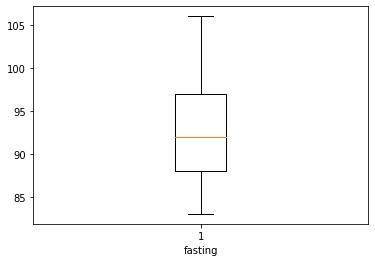

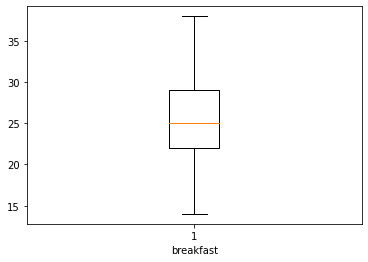

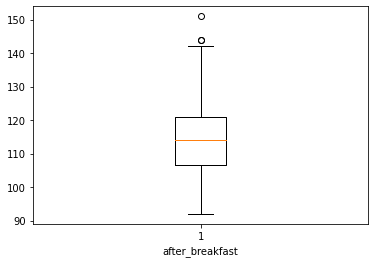

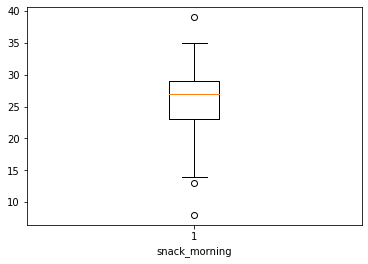

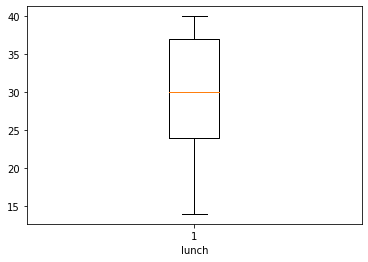

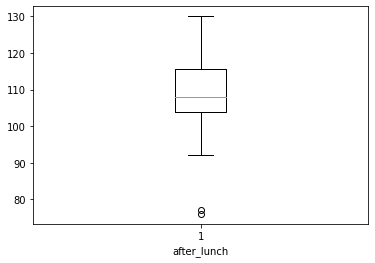

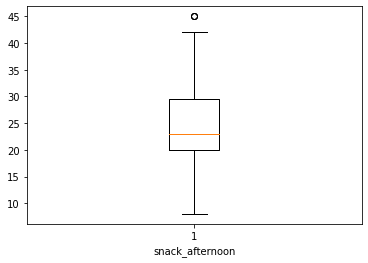

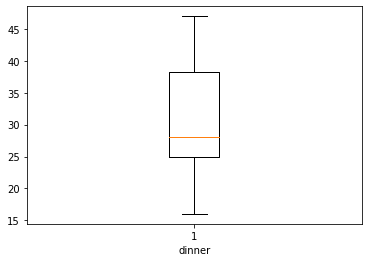

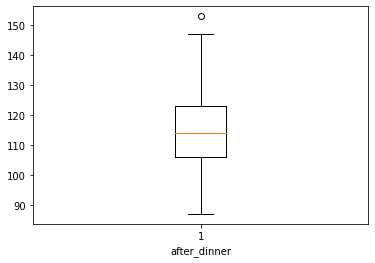

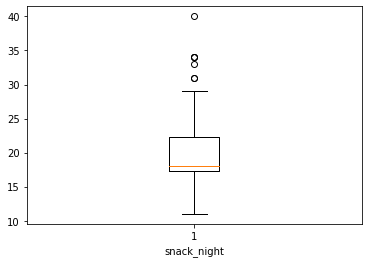

In [58]:
for sub in df['subtype'].unique():
    plt.figure()
    plt.boxplot(df[df.subtype == sub].value)
    plt.xlabel(sub)

In [59]:
df[(df.subtype == 'snack_night') & (df.value > 30)]

,type,value,unit,notes,month,date,daycount,subtype,outOfRange
datetime,,,,,,,,,
2021-03-22 21:35:00,Carbs,34,g,"1/2 dessert smoothie, 1 piece toast with peanu...",3,2021-03-22,12,snack_night,True
2021-03-29 19:52:00,Carbs,40,g,"Chocolate chip waffle, carrots and Bitchin'Sauce",3,2021-03-29,19,snack_night,True
2021-04-09 21:50:00,Carbs,34,g,"Frozen kind bar, atkins bar",4,2021-04-09,30,snack_night,True
2021-04-11 20:35:00,Carbs,34,g,Frozen kind bar,4,2021-04-11,32,snack_night,True
2021-04-19 20:50:00,Carbs,33,g,So Delicious peanut butter ice cream bar,4,2021-04-19,40,snack_night,True
2021-04-29 20:43:00,Carbs,31,g,Chocolate almonds,4,2021-04-29,50,snack_night,True
2021-05-08 21:02:00,Carbs,31,g,Chocolate almonds,5,2021-05-08,59,snack_night,True


**We don't need the notes column now that the subtypes are all set**

In [60]:
df.drop('notes', axis=1, inplace=True)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 693 entries, 2021-03-11 07:11:00 to 2021-05-23 21:56:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   type        693 non-null    object
 1   value       693 non-null    int64 
 2   unit        693 non-null    object
 3   month       693 non-null    int64 
 4   date        693 non-null    object
 5   daycount    693 non-null    int64 
 6   subtype     693 non-null    object
 7   outOfRange  693 non-null    bool  
dtypes: bool(1), int64(3), object(4)
memory usage: 60.2+ KB


### Daily dataframe

<p>daily df should have this structure:<br />
    ['daycount', 'datetime', 'bg_fasting', 'bg_avg', 'carbs_sum', 'meds_dose']</p>

In [62]:
datetime = pd.to_datetime(df.date.unique())

**fasting column**

In [63]:
fasting = df[df.subtype == 'fasting'].groupby('daycount').sum().value

In [64]:
dict(itertools.islice(fasting.items(), 0 ,5))

{1: 104, 2: 101, 3: 96, 4: 93, 5: 89}

**bg_avg is the daily average excluding the fasting value**

In [65]:
no_fasting = df[df.subtype != 'fasting']
no_fasting.subtype.unique()

array(['breakfast', 'after_breakfast', 'snack_morning', 'lunch',
       'after_lunch', 'snack_afternoon', 'dinner', 'after_dinner',
       'snack_night'], dtype=object)

In [66]:
bg_avg = no_fasting[no_fasting.type == 'Blood Sugar Reading'].groupby('daycount').mean().value
bg_avg = bg_avg.astype('int64')
dict(itertools.islice(bg_avg.items(), 0 ,5))

{1: 109, 2: 110, 3: 120, 4: 106, 5: 108}

In [67]:
# is 109 the correct bg average for day 1
df[df.daycount == 1]

,type,value,unit,month,date,daycount,subtype,outOfRange
datetime,,,,,,,,
2021-03-11 07:11:00,Blood Sugar Reading,104,mg/dL,3,2021-03-11,1,fasting,True
2021-03-11 08:01:00,Carbs,26,g,3,2021-03-11,1,breakfast,False
2021-03-11 09:20:00,Blood Sugar Reading,121,mg/dL,3,2021-03-11,1,after_breakfast,False
2021-03-11 11:18:00,Carbs,27,g,3,2021-03-11,1,snack_morning,False
2021-03-11 13:30:00,Carbs,30,g,3,2021-03-11,1,lunch,False
2021-03-11 14:35:00,Blood Sugar Reading,119,mg/dL,3,2021-03-11,1,after_lunch,False
2021-03-11 17:30:00,Carbs,13,g,3,2021-03-11,1,snack_afternoon,False
2021-03-11 18:55:00,Carbs,42,g,3,2021-03-11,1,dinner,False
2021-03-11 19:54:00,Blood Sugar Reading,87,mg/dL,3,2021-03-11,1,after_dinner,False


In [68]:
(121 + 119 + 87) / 3

109.0

**making the carbs_sum column is easy: we just need to sum up all of the carbs per daycount**

In [69]:
carbs = df[df.type == 'Carbs'].groupby('daycount').sum().value

In [70]:
dict(itertools.islice(carbs.items(), 0 ,5))

{1: 138, 2: 157, 3: 154, 4: 87, 5: 135}

In [71]:
daily = pd.DataFrame({
    'date': datetime, 
    'bg_fasting': fasting.astype('int64'), 
    'bg_avg': bg_avg, 
    'carbs_sum': carbs})

In [72]:
daily

,date,bg_fasting,bg_avg,carbs_sum
daycount,,,,
1,2021-03-11,104.0,109,138
2,2021-03-12,101.0,110,157
3,2021-03-13,96.0,120,154
4,2021-03-14,93.0,106,87
5,2021-03-15,89.0,108,135
6,2021-03-16,92.0,108,110
7,2021-03-17,100.0,98,151
8,2021-03-18,98.0,114,136
9,2021-03-19,100.0,128,136


**time for meds_dose**

<p>April 28 2000mg<br />
April 15 1500mg<br />
April 9 1000mg<br />
April 2 500mg</p>

In [73]:
daily['meds_dose'] = 0

In [74]:
import datetime
daily.loc[daily.date >= pd.to_datetime('2021-04-02'), 'meds_dose'] = 500
daily.loc[daily.date >= pd.to_datetime('2021-04-09'), 'meds_dose'] = 1000
daily.loc[daily.date >= pd.to_datetime('2021-04-15'), 'meds_dose'] = 1500
daily.loc[daily.date >= pd.to_datetime('2021-04-28'), 'meds_dose'] = 2000


In [75]:
daily[['date', 'meds_dose']]

,date,meds_dose
daycount,,
1,2021-03-11,0
2,2021-03-12,0
3,2021-03-13,0
4,2021-03-14,0
5,2021-03-15,0
6,2021-03-16,0
7,2021-03-17,0
8,2021-03-18,0
9,2021-03-19,0


**Actually, the date should be the index**

In [76]:
daily = daily.reset_index().set_index('date').asfreq('D')

In [77]:
daily.describe()

,daycount,bg_fasting,bg_avg,carbs_sum,meds_dose
count,74.000000,73.000000,74.000000,74.000000,74.000000
mean,37.500000,93.027397,112.459459,145.364865,1094.594595
std,21.505813,5.908968,7.811458,20.599624,846.732947
min,1.000000,83.000000,94.000000,87.000000,0.000000
25%,19.250000,88.000000,108.000000,134.000000,0.000000
50%,37.500000,92.000000,112.500000,145.000000,1500.000000
75%,55.750000,97.000000,117.500000,160.750000,2000.000000
max,74.000000,106.000000,134.000000,180.000000,2000.000000


In [78]:
missing = daily[daily.bg_fasting.isna()]
missing

,daycount,bg_fasting,bg_avg,carbs_sum,meds_dose
date,,,,,
2021-05-17,68,NaN,103,135,2000


In [79]:
m17_mean = daily[(daily.daycount >= 66) & (daily.daycount <= 70)]['bg_fasting'].mean()

In [80]:
daily.loc[missing.index, 'bg_fasting'] = m17_mean

In [81]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74 entries, 2021-03-11 to 2021-05-23
Freq: D
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   daycount    74 non-null     int64  
 1   bg_fasting  74 non-null     float64
 2   bg_avg      74 non-null     int64  
 3   carbs_sum   74 non-null     int64  
 4   meds_dose   74 non-null     int64  
dtypes: float64(1), int64(4)
memory usage: 5.5 KB


In [82]:
daily[daily.bg_avg.isna()]

,daycount,bg_fasting,bg_avg,carbs_sum,meds_dose
date,,,,,


### Light Data Visualization

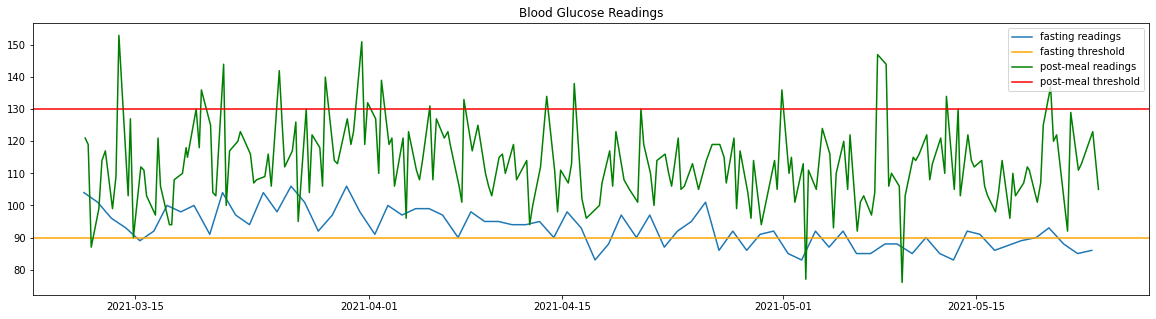

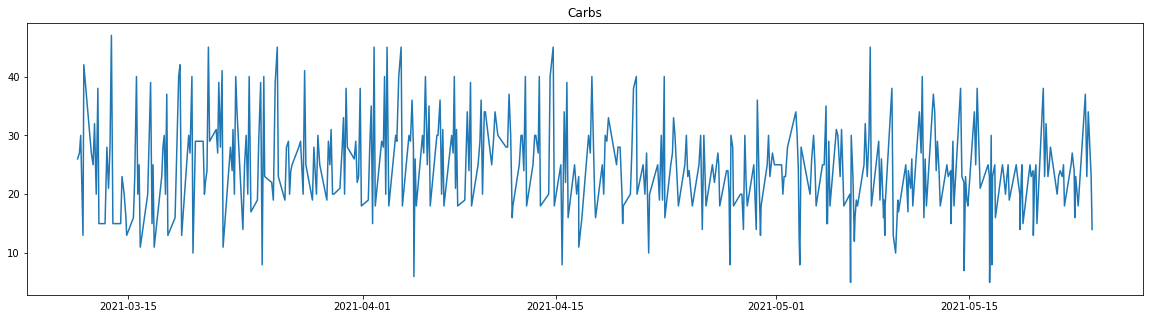

In [83]:
bg_fast = df[df['subtype'] == 'fasting']
bg_meal = df[df['subtype'].isin(['after_breakfast', 'after_lunch', 'after_dinner'])]

plt.figure(figsize=(20,5))
plt.plot(bg_fast.index, bg_fast.value, label='fasting readings')
plt.axhline(90, color='orange', label='fasting threshold')
plt.plot(bg_meal.index, bg_meal.value, label='post-meal readings', color='green')
plt.axhline(130, color='red', label='post-meal threshold')
plt.title('Blood Glucose Readings')
plt.legend(loc='upper right')
plt.show()

carb = data[data.type == 'Carbs']
# snack_afternoon = data[data.subtype == 'snack_afternoon']

plt.figure(figsize=(20,5))
plt.plot(carb.index, carb.value)
plt.title('Carbs')
plt.show()

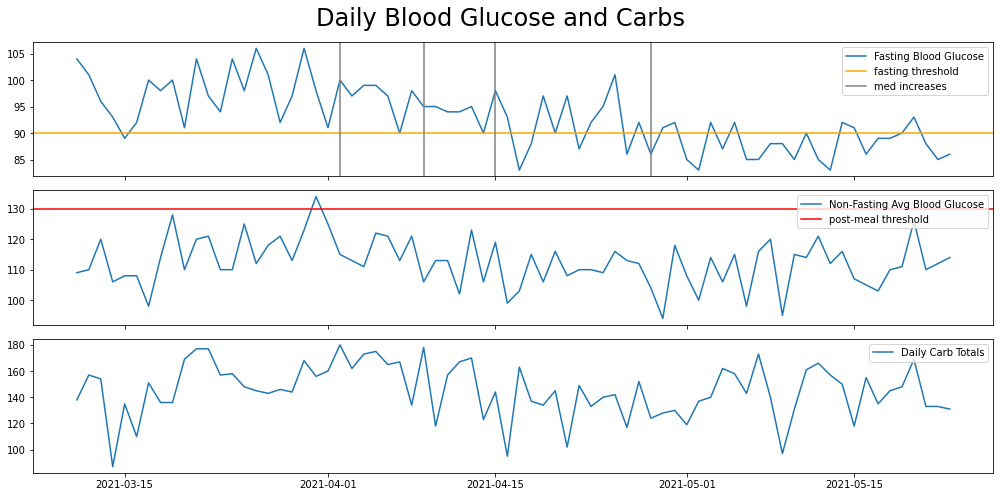

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14,7))
fig.suptitle('Daily Blood Glucose and Carbs', fontsize=24)
ax1.plot(daily.index, daily.bg_fasting, label='Fasting Blood Glucose')
ax2.plot(daily.index, daily.bg_avg, label='Non-Fasting Avg Blood Glucose')
ax3.plot(daily.index, daily.carbs_sum, label='Daily Carb Totals')

ax1.axhline(90, color='orange', label='fasting threshold')
ax1.axvline(pd.to_datetime('2021-04-02'), color='gray', label='med increases')
ax1.axvline(pd.to_datetime('2021-04-09'), color='gray')
ax1.axvline(pd.to_datetime('2021-04-15'), color='gray')
ax1.axvline(pd.to_datetime('2021-04-28'), color='gray')

ax2.axhline(130, color='red', label='post-meal threshold')

# ax3.set_xticks(daily.index)

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
ax3.legend(loc='upper right')

plt.tight_layout()
plt.savefig('vis/daily_graphs.png', bbox_inches="tight")

In [ ]:
daily.index

### Setting the target variable

In [ ]:
y = daily['bg_avg'].asfreq('D')
y[y.isna()]

In [ ]:
y

In [ ]:
# y[y.isna()] = 109

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 12,8

# Plot the original data, the trend, the seasonality, and the residuals 
decomp_add = seasonal_decompose(y.asfreq('D'), model='additive')
decomp_add.plot()

decomp_mlt = seasonal_decompose(y.asfreq('D'), model='multiplicative')
decomp_mlt.plot()

## Saving the data

In [ ]:
# save the data to a new csv file

datapath = 'data'
save_file(df.reset_index(), 'data_cleaned.csv', datapath)
save_file(daily.reset_index(), 'daily_cleaned.csv', datapath)